In [8]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit,minimize
%matplotlib inline
from tqdm.auto import tqdm
import matplotlib.patheffects as pe
import scipy
import quaternion

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
from matplotlib.gridspec import GridSpec

figaspectratio = 1.25

In [9]:
def chi2(x,y,sy):
    return(np.sum(np.square(x-y)/sy**2))

def fixed_axis_lightcurve(theta,a,b,c):
    dist=np.abs(np.sin(theta)*np.tan(theta)*a**2+c**2*np.cos(theta))
    beta=np.sqrt(c**2+a**2*np.tan(theta)**2)

    return(np.pi*b*dist/beta)

def fixedHfunction(time,p,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    curve=deltaV-2.5*np.log10(fixed_axis_lightcurve(beta-betainit,115,111,19))
    return(curve)

def arbitrary_axis_lightcurve(theta,a,b,c,rot=[0,1,0],obs=[1,0,0],N=250):
    ndata=theta.size
    obs=np.quaternion(0,*obs)
    
    # Generate x,y points
    x=np.linspace(-a,a,N)
    y=np.linspace(-b,b,N)
    
    X,Y=np.meshgrid(x,y,indexing='ij')
    
    # Remove the points outside of bounds
    pts_in=np.where(X**2/a**2+Y**2/b**2<=1)
    X=X[pts_in]
    Y=Y[pts_in]
    
    # Generate z points for the x and y points
    z=c*np.sqrt(np.abs(1-X**2/a**2-Y**2/b**2))
    
    # Get +/- z points
    x=np.append(X,X)
    y=np.append(Y,Y)
    z=np.append(z,-z)
    
    npts=z.size
    
    # Combine points
    pts=np.array([x,y,z]).T
    pts=np.tile(pts[:,:,np.newaxis],ndata)
        
    rot=rot/np.sqrt(np.sum(np.square(rot)))
    nrot=np.outer(np.array(rot),np.sin(theta/2))
    nrot=np.append(np.cos(theta[np.newaxis,:]/2),nrot,axis=0)
    
    q=quaternion.as_quat_array(nrot.T)
    q*=1/np.abs(q)
    
    obs=np.conj(q)*obs*q
    obs=quaternion.as_float_array(obs)[:,1:]
    
    obs=np.repeat(obs.T[np.newaxis,:,:],npts,axis=0)
    
    inner=np.sum(pts*obs,axis=1)
    inner=np.repeat(inner[:,np.newaxis,:],3,axis=1)
    
    proj=pts-inner*obs
    proj=np.append(np.zeros((npts,ndata))[:,np.newaxis,:],proj,axis=1)    
    
    proj=np.moveaxis(proj,1,2)
    proj=quaternion.as_quat_array(proj)
    
    q=np.repeat(q[np.newaxis,:],npts,axis=0)
    
    proj=q*proj*np.conj(q)
    proj=quaternion.as_float_array(proj)
    proj=proj[:,:,2:]
    
    output=[]
    for i in tqdm(range(ndata),desc='Hull Loop',leave=True):
        hull=scipy.spatial.ConvexHull(proj[:,i,:])
        output.append(hull.volume)
        
    return(np.array(output))

def arbitraryHfunction(time,p,phi,psi,betainit,deltaV):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p
    
    rot=[np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]
    curve=deltaV-2.5*np.log10(arbitrary_axis_lightcurve(beta-betainit,115,111,19,rot=rot,N=50))
    return(curve)

Hull Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/500 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/500 [00:00<?, ?it/s]

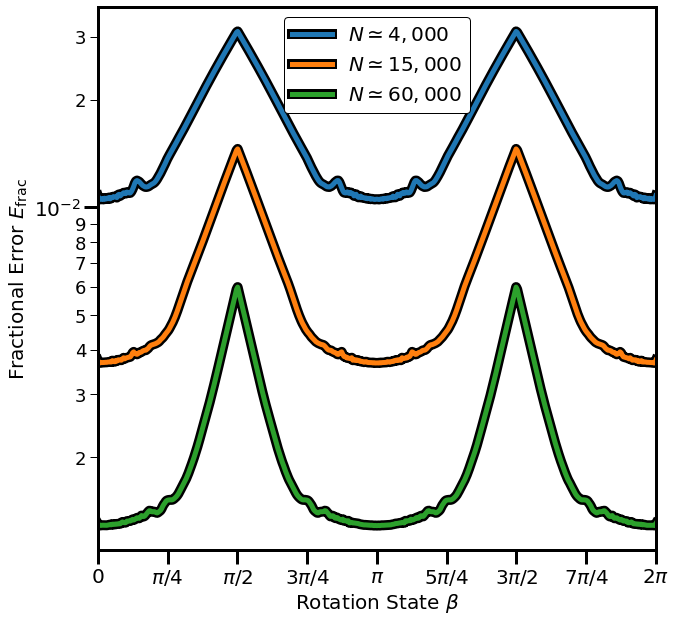

In [10]:
def fmt(x, pos):
    b=np.floor(np.log10(x))
    a=x/10**b
    return("{:.0f}".format(a,b))

theta_data = np.linspace(0, 2*np.pi, 500)

simple = (fixed_axis_lightcurve(theta_data, 115, 111, 19))
light1 = (arbitrary_axis_lightcurve(theta_data, 115,111,19, N=50))
light2 = (arbitrary_axis_lightcurve(theta_data, 115,111,19, N=100))
light3 = (arbitrary_axis_lightcurve(theta_data, 115,111,19, N=200))

fig=plt.figure(figsize=(10, 10))
ax=plt.gca()
#plt.plot(theta_data,simple)
plt.plot(theta_data, np.abs(light1-simple)/simple,lw=5,
         path_effects=[pe.Stroke(linewidth=10, foreground='k'), pe.Normal()])
plt.plot(theta_data, np.abs(light2-simple)/simple,lw=5,
         path_effects=[pe.Stroke(linewidth=10, foreground='k'), pe.Normal()])
plt.plot(theta_data, np.abs(light3-simple)/simple,lw=5,
         path_effects=[pe.Stroke(linewidth=10, foreground='k'), pe.Normal()])
#plt.plot(theta_data,light3)
plt.yscale('log')
plt.legend([r"$N\simeq 4,000$", r"$N\simeq 15,000$", r"$N\simeq 60,000$"],loc='best',
           fancybox=True,edgecolor='black',facecolor='white',framealpha=1)
plt.xticks(np.pi*np.linspace(0, 2, 9),
           labels=[0, "$\\pi/4$", "$\\pi/2$", "$3\\pi/4$", "$\\pi$",
                   "$5\\pi/4$", "$3\\pi/2$", "$7\\pi/4$", "$2\\pi$"])
plt.xlabel(r"Rotation State $\beta$")
plt.ylabel(r"Fractional Error $E_{\rm frac}$")
plt.xlim([0,2*np.pi])
ax.yaxis.set_minor_formatter(ticker.FuncFormatter(fmt))
ax.tick_params(axis='y',which='minor',labelsize=18)


plt.savefig("../Figures and Paper/num_lightcurve_comp.pdf", bbox_inches='tight',
            dpi=150)

In [11]:
belton=pd.read_csv("../Lightcurves/Photometry/1I_2017U1_lightcurve.csv",comment='#')

beltime=belton['corrMMJD'].to_numpy()
belmag=belton['corrm'].to_numpy()
belsig=belton['sigma'].to_numpy()
belalpha=belton['aPh'].to_numpy()

belton=np.array([beltime,belmag,belsig]).T

cutoff=55.5
octbeltime=beltime[beltime<cutoff]
octbelmag=belmag[beltime<cutoff]
octbelsig=belsig[beltime<cutoff]

cutoff=78
novbeltime=beltime[beltime>cutoff]
novbelmag=belmag[beltime>cutoff]
novbelsig=belsig[beltime>cutoff]

In [12]:
arbpopt,_=curve_fit(arbitraryHfunction,octbeltime,octbelmag,p0=[7.36,1.5,np.pi/2,1.7,33.25],
                    sigma=octbelsig,absolute_sigma=False,
                    bounds=([5,0,0,0,20],[10,np.pi,2*np.pi,2*np.pi,40]),maxfev=5000)

times=np.linspace(np.min(beltime),np.max(beltime)+0.1,10000)
curve=arbitraryHfunction(times,*arbpopt)

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

Hull Loop:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
print(arbpopt)
print(chi2(arbitraryHfunction(octbeltime,*arbpopt),octbelmag,octbelsig))

[ 7.38905948  1.47609487  2.3016331   0.96893594 33.13836934]


Hull Loop:   0%|          | 0/965 [00:00<?, ?it/s]

28714.631781685755


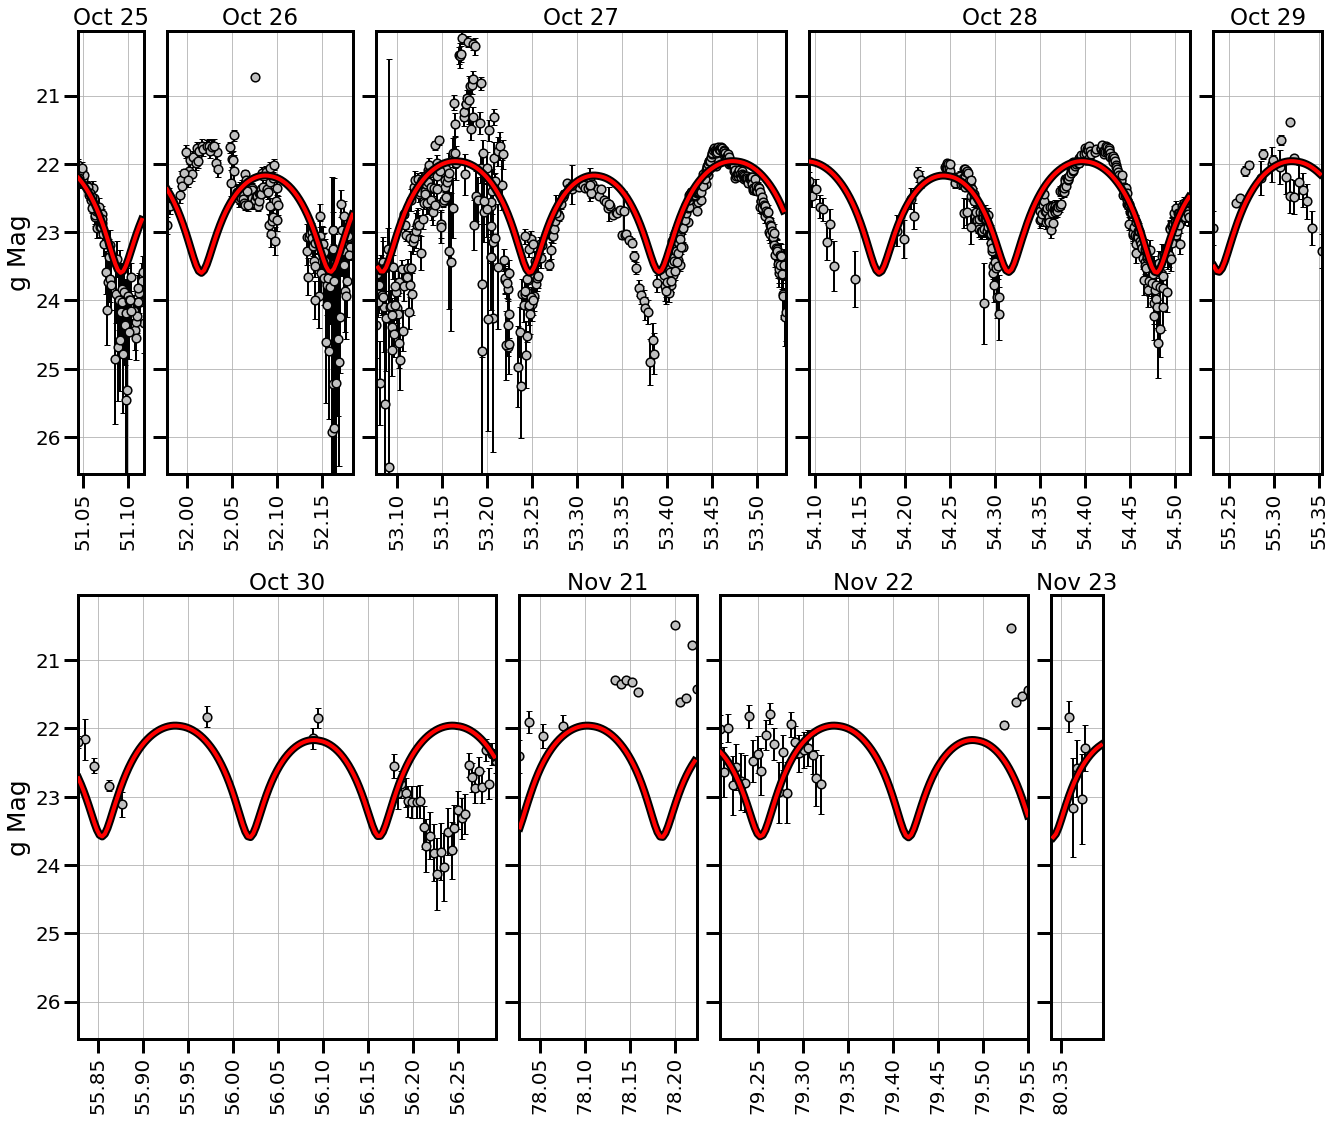

In [14]:
import matplotlib.ticker as ticker

figx,figy=16,14
fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

labels=['Oct 25','Oct 26','Oct 27','Oct 28','Oct 29','Oct 30','Nov 21','Nov 22','Nov 23']
days=np.unique(beltime//1)-.25

limits=[]
for d in days:
    xmin=np.min(beltime[((beltime+.25)//1-.25)==d])
    xmax=np.max(beltime[((beltime+.25)//1-.25)==d])
    if (xmax-xmin)<0.05:
        xmin-=0.02
        xmax+=0.02
    limits.append((xmin,xmax))

axspace=0.02
tickspace=0.05

yspace=0.06

toprow=5
totalwidth=0
for i in range(5):
    totalwidth+=limits[i][1]-limits[i][0]
platescale=1/totalwidth

corner=0

axes=[]
for i in range(len(days)):
    xmin,xmax=limits[i]
    dx = (xmax-xmin)*platescale
    if i//5 == 0:
        ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
    else:
        ax=fig.add_axes([corner,0,dx,0.5-yspace])
    axes.append(ax)
    ax.set_xlim([xmin,xmax])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
    ax.set_title(labels[i],fontsize=23)
    ax.errorbar(belton[:,0][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  belton[:,1][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  yerr=belton[:,2][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))], 
                  fmt='none',ecolor='k',elinewidth=2,capsize=3,rasterized=True)
    ax.scatter(belton[:,0][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  belton[:,1][np.where((belton[:,0]<=xmax)&(belton[:,0]>=xmin))],
                  s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2,rasterized=True)
    ax.plot(times[np.where((times<=xmax)&(times>=xmin))],
                 curve[np.where((times<=xmax)&(times>=xmin))],
                 color='r',zorder=3,lw=4,path_effects=[pe.Stroke(linewidth=8, foreground='k'), pe.Normal()])
    plt.xticks(rotation=90)
    corner+=dx+axspace
    
    if i%5 == 0:
        ax.set_ylabel("g Mag", fontsize=25)
    else:
        ax.set_yticklabels([])
    
    if i==4: corner=0

for ax in axes:
    ax.grid()
    ax.set_ylim([ymax,ymin])
    
plt.savefig('../Figures and Paper/arbitrary_axis_lightcurve.pdf',
           bbox_inches='tight',dpi=150)